<a href="https://colab.research.google.com/github/DONDAJIN/Kaggle_amex/blob/master/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import cupy
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
import warnings
warnings.simplefilter('ignore')
import os

In [5]:
DIR='/content/drive/MyDrive'
Kaggle=os.path.join(DIR,'Kaggle')
os.makedirs(Kaggle, exist_ok=True)

In [6]:
INPUT=os.path.join(Kaggle,'Input')
OUTPUT=os.path.join(Kaggle,'Output')
os.makedirs(INPUT,exist_ok=True)
os.makedirs(OUTPUT,exist_ok=True)

In [7]:
train_df=pd.read_parquet(os.path.join(INPUT,'train.parquet'))#ランタイムの設定をハイメモリにして読み込む
test_df=pd.read_parquet(os.path.join(INPUT,'test.parquet'))

In [ ]:
train_df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0,0.008724,1.006838,0.009228,0.124035,0.0,0.004709,...,-1,-1,-1,0,0,0.0,NaN,0,0.000610,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0,0.004923,1.000653,0.006151,0.126750,0.0,0.002714,...,-1,-1,-1,0,0,0.0,NaN,0,0.005492,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,3,0.021655,1.009672,0.006815,0.123977,0.0,0.009423,...,-1,-1,-1,0,0,0.0,NaN,0,0.006986,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0,0.013683,1.002700,0.001373,0.117169,0.0,0.005531,...,-1,-1,-1,0,0,0.0,NaN,0,0.006527,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0,0.015193,1.000727,0.007605,0.117325,0.0,0.009312,...,-1,-1,-1,0,0,0.0,NaN,0,0.008126,0


In [8]:
train_df.columns

Index(['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41',
       'B_3',
       ...
       'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=190)

In [ ]:
#!cp "/content/drive/My Drive/train_labels.csv.zip" .

In [ ]:
#!unzip train_labels.csv.zip

Archive:  train_labels.csv.zip
  inflating: train_labels.csv        


In [9]:
y=pd.read_csv(os.path.join(INPUT,'train_labels.csv'))

In [10]:
train_df.columns[train_df.dtypes=='O']

Index(['customer_ID', 'S_2'], dtype='object')

In [ ]:
cat_col=['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [ ]:
train_df['D_87'].value_counts()

-1    5527586
 1       3865
Name: D_87, dtype: int64

匿名化された特徴量が扱いにくすぎる…

カテゴリ変数と定義されたものがあるのでそれをうまく使うのが鍵か？

CatboostとLGBMは少なくとも試したい
それでfeature_importancesを見ていく感じ




In [20]:
y.isna().any().sum(),y['customer_ID'].duplicated().any()

(0, False)

In [21]:
y.head()

,customer_ID,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0


In [22]:
label_stats=pd.DataFrame({'absolute':y['target'].value_counts(),
                          'relative':y['target'].value_counts()/len(y['target'])})
label_stats

,absolute,relative
0,340085,0.741066
1,118828,0.258934


In [23]:
print('Train Statement dates:' ,train_df['S_2'].min(),
      train_df['S_2'].max(),train_df['S_2'].isna().any())
print('Test Statement dates:',test_df['S_2'].min(),
      test_df['S_2'].max(),test_df['S_2'].isna().any())

Train Statement dates: 2017-03-01 2018-03-31 False
Test Statement dates: 2018-04-01 2019-10-31 False


* trainデータとtestデータで期間が違う
(train:3月から次の年の3月
test:4月から次の年の10月)
### だから時間的な効果をモデルに組み込めない

In [25]:
print(f'train data memory usage:{train_df.memory_usage().sum()/1e9} GBytes')
print(f'test data memory usage: {test_df.memory_usage().sum()/1e9} GBytes')

train data memory usage:2.72147402 GBytes
test data memory usage: 5.602334794 GBytes


* データ量が膨大なのでメモリーの効率化が必要、不必要なモデルのコピーも避けるべきだろう
* 同時にtrainとtestを持たないために二つのノートブックを使うべきかも(Google colab proならぎりぎりRAMは耐えてる)

In [30]:
train_df.info(max_cols=200,show_counts=True) #show_counts:Trueでnull以外のカウントを表示

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Data columns (total 190 columns):
 #    Column       Non-Null Count    Dtype  
---   ------       --------------    -----  
 0    customer_ID  5531451 non-null  object 
 1    S_2          5531451 non-null  object 
 2    P_2          5485466 non-null  float32
 3    D_39         5531451 non-null  int16  
 4    B_1          5531451 non-null  float32
 5    B_2          5529435 non-null  float32
 6    R_1          5531451 non-null  float32
 7    S_3          4510907 non-null  float32
 8    D_41         5529435 non-null  float32
 9    B_3          5529435 non-null  float32
 10   D_42         791314 non-null   float32
 11   D_43         3873055 non-null  float32
 12   D_44         5531451 non-null  int8   
 13   B_4          5531451 non-null  int16  
 14   D_45         5529434 non-null  float32
 15   B_5          5531451 non-null  float32
 16   R_2          5531451 non-null  int8   
 17   D_46         4319752 non-

* 決定木ならnull埋め必要ないがnn使うならやらないといけないな～

In [31]:
train_df['customer_ID'].value_counts()

0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a    13
a3111280bfa1ed8fafd0b06839eb707f4538497e8087cb62958bb03e1bdde214    13
a31376930229162f886c091e5a56a528f81c10a523285828ed05a6e9ccf56722    13
a312c595dfaee96c8a597107d2754a49b1acfd127400d98991762d87837b1b65    13
a312aff722e7230f9d6a313ff777d6f00166c6bada21a333982426758a2e2a9d    13
                                                                    ..
a84839802f1f37a86a7fe34ddba4791d33d878df3937b509841def0a9e252748     1
01f4f7b14d83b6a8f88e4355279224615da083b19e3e5f15b98f274ced8cf752     1
eef07ea56302cebcd57374c6565bb3e5c7af856796d9cbc31ed42aa0fc73b7fc     1
d192480082e86e3b4da68f014b284f2a2624b45956eed279416c796de043b7ce     1
d9ea3cffff889b522a69bde89aee382dcff8bffe32c9a38653bdaa2ff4330041     1
Name: customer_ID, Length: 458913, dtype: int64

In [41]:
#fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,5))
#train_vc=train_df['customer_ID'].value_counts().sort_index(ascending=False).rename('Trainstatements per customer')
#ax1.pie(train_vc,labels=train_vc.index) #.value_counts()でindexがユニークな要素の値、その出現個数がdataとなってその降順になる。
#ax1.set_title(train_vc.name)
#test_vc=test_df['customer'].value_counts().sort_index(ascending=False).rename('Test statements per customer')
#ax2.pie(test_vc,labels=test_vc.index)
#ax2.set_title(test_vc.name)
#plt.show()
#重すぎて実行できない

* 一人のcustomer当たり大体13個のstatementがあり、(1か月に1つ)他はそれ以下の数

In [45]:
temp=train_df['S_2'].groupby(train_df['customer_ID']).max()
#train_df['customer_ID']のuniqueな値に対してtrain_dfの['S_2']のindexがそれぞれ対応し、そのmaxのindexが出される。

customer_ID
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a    2018-03-13
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5    2018-03-25
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1    2018-03-12
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc    2018-03-29
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed    2018-03-30
                                                                       ...    
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7    2018-03-31
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286    2018-03-22
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6    2018-03-07
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145b2c3d01967fcce461    2018-03-23
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681    2018-03-14
Name: S_2, Length: 458913, dtype: object

In [60]:
tmp=train_df['S_2'].groupby(train_df['customer_ID']).groups
tmp

{'0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], '00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5': [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], '00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1': [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38], '000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc': [39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51], '00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed': [52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64], '000084e5023181993c2e1b665ac88dbb1ce9ef621ec5370150fc2f8bdca6202c': [65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77], '000098081fde4fd64bc4d503a5d6f86a0aedc425c96f5235f98b0f47c9d7d8d4': [78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90], '0000d17a1447b25a01e42e1ac56b091bb7cbb06317be4cb59b50fec59e0b6381': [91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103], '0000f99513770170a1aba690daee

In [61]:
import gc
gc.collect()

377

In [65]:
train_df['S_2']=train_df['S_2'].astype('datetime64')

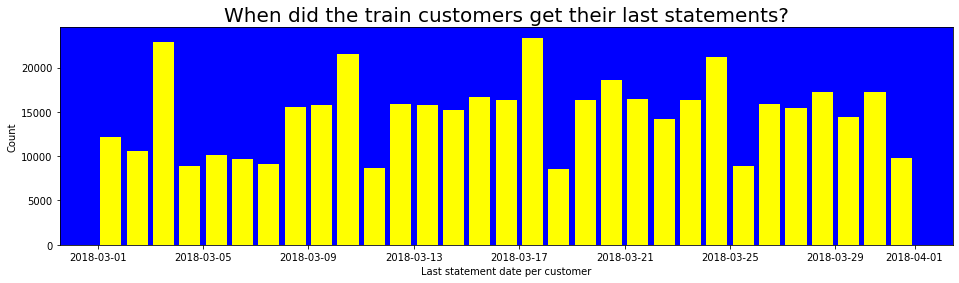

In [66]:
temp=train_df['S_2'].groupby(train_df['customer_ID']).max()
plt.figure(figsize=(16,4))#freq='d'で毎日
plt.hist(temp,bins=pd.date_range("2018-03-01","2018-04-01",freq='d'),rwidth=0.8,color='yellow')
plt.title('When did the train customers get their last statements?',fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Count')
plt.gca().set_facecolor('blue') #get current axis　実質ax.set_facecolor(背景色)
plt.show()
del temp

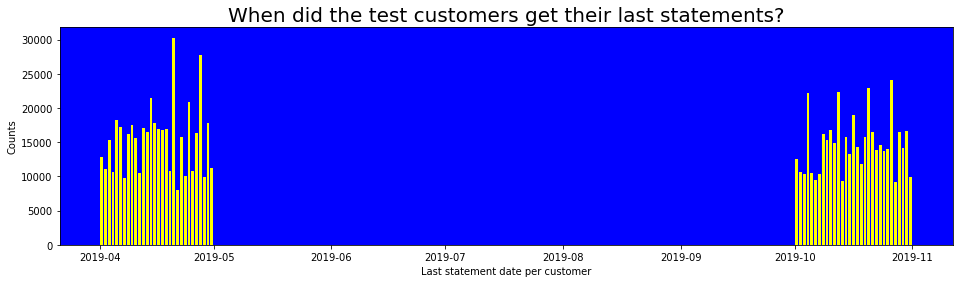

In [67]:
test_df['S_2']=test_df['S_2'].astype('datetime64')
temp=test_df['S_2'].groupby(test_df['customer_ID']).max()
plt.figure(figsize=(16,4))
plt.hist(temp,bins=pd.date_range("2019-04-01","2019-11-01",freq='d'),rwidth=0.74,color='yellow')
plt.title('When did the test customers get their last statements?',fontsize=20)
plt.xlabel('Last statement date per customer')
plt.ylabel('Counts')
plt.gca().set_facecolor('blue')
plt.show()
del temp

* 全てのtrainが同じ月に起こっているからTimeSplit Validationができない

In [68]:
cat_features=['B_30','B_38','D_114','D_117','D_120','D_126','D_63','D_64',
'D_64','D_66','D_68']

In [69]:
bin_features=['B_31','D_87']

In [71]:
numeric_features=[f for f in train_df.columns if f not in cat_features+bin_features+['customer_ID','target']]
print(len(numeric_features))

177


In [72]:
#ncols=4
#for i,f in enumerate(numeric_features):
  #if i% ncols ==0: #左から4番目ならplt.show()をする
    #if i>0:plt.show()
    #plt.figure(figsize=(16,3))
    #if i==0:plt.suptitle('Continuous features',fontsize=20,y=1.02)
    #plt.subplot(1,ncols,i%ncols+1)
    #plt.hist(train_df[f],bins=200)
    #plt.xlabel(f)
#plt.show()